<a href="https://colab.research.google.com/github/Deeksha-Analyst/Project---Integrated-Retail-Analytics-for-Store-Optimization-and-Demand-Forecasting-/blob/main/colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Project -"Integrated Retail Analytics for Store Optimization and Demand Forecasting"**

# **Project Objective** -To utilize machine learning and data analysis techniques to optimize store performance, forecast demand, and enhance customer experience through segmentation and personalized marketing strategies.

Project Components:

1 Anomaly Detection in Sales Data -Goal: Identify and handle irregularities in sales data that could distort forecasting and analysis.
Statistical thresholds (IQR, Z-score) to flag extreme values. Detected anomalies across stores and departments.

2 Identify unusual sales patterns across stores and departments.

3 Investigate potential causes e.g., holidays, markdowns, economic indicators.

4 Time-Based Anomaly Detection:Goal: Understand temporal sales patterns and identify irregular trends.Moving averages and seasonal trend decomposition.insight=Seasonal peaks during holidays and promotional periods.
5 Customer Segmentation Analysis:
6 Data Preprocessing and Feature Engineering
Goal: Prepare clean, enriched data for forecasting and modeling.
step=Imputed missing values using:
Median/mode for categorical data.



















In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import lightgbm as lgb
import xgboost as xgb

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
Features_data  = pd.read_csv('/content/drive/MyDrive/Integrated Retail Analytics for Store Optimization and Demand Forecasting/Features data set.csv')
sales_data = pd.read_csv('/content/drive/MyDrive/Integrated Retail Analytics for Store Optimization and Demand Forecasting/sales data-set.csv')
stores_data = pd.read_csv('/content/drive/MyDrive/Integrated Retail Analytics for Store Optimization and Demand Forecasting/stores data-set.csv')


In [4]:
# Merge features with store info
merged_df = pd.merge(Features_data, stores_data, on='Store', how='left')

# Merge with sales data
final_df = pd.merge(merged_df, sales_data, on=['Store', 'Date'], how='left')


In [5]:

Features_data['Date'] = pd.to_datetime(Features_data['Date'], format = 'mixed')
sales_data['Date'] = pd.to_datetime(sales_data['Date'], format = 'mixed')

In [6]:
df = pd.merge(sales_data, Features_data, how = 'left', on = ['Store','Date','IsHoliday']) # merging sales and features by left since there are more rows for sales
df_new = pd.merge(df, stores_data, how = 'left', on = 'Store') #merge df and df_stores by left to keep all the columns and rows
df_new = df_new.fillna(0)

In [7]:
print(merged_df.columns)


Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Type', 'Size'],
      dtype='object')


In [8]:
merged_df.rename(columns={"Weekly_seles": "Weekly_Sales"}, inplace=True)


In [9]:
cat_cols =['Store', 'Dept', 'IsHoliday', 'Type']
num_cols = df_new.columns.drop(cat_cols)
num_cols = num_cols.drop('Date') # Drop 'Date' column from numerical columns

print('Categorical Variables:')
print(cat_cols)

print('Numerical Variables:')
print(num_cols)

Categorical Variables:
['Store', 'Dept', 'IsHoliday', 'Type']
Numerical Variables:
Index(['Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size'],
      dtype='object')


In [10]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423325 entries, 0 to 423324
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         423325 non-null  int64  
 1   Date          423325 non-null  object 
 2   Temperature   423325 non-null  float64
 3   Fuel_Price    423325 non-null  float64
 4   MarkDown1     152433 non-null  float64
 5   MarkDown2     112532 non-null  float64
 6   MarkDown3     138658 non-null  float64
 7   MarkDown4     136466 non-null  float64
 8   MarkDown5     153187 non-null  float64
 9   CPI           422740 non-null  float64
 10  Unemployment  422740 non-null  float64
 11  IsHoliday_x   423325 non-null  bool   
 12  Type          423325 non-null  object 
 13  Size          423325 non-null  int64  
 14  Dept          421570 non-null  float64
 15  Weekly_Sales  421570 non-null  float64
 16  IsHoliday_y   421570 non-null  object 
dtypes: bool(1), float64(11), int64(2), object(3)
mem

In [11]:
Features_data.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [12]:
Features_data.shape

(8190, 12)

In [13]:
sales_data.shape

(421570, 5)

In [14]:
stores_data.shape

(45, 3)

In [15]:
sales_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


In [16]:
stores_data.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [17]:
stores_data.isnull().sum()

,0
Store,0
Type,0
Size,0


In [18]:
Features_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 712.0 KB


In [19]:
Features_data.describe()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,2011-11-04 13:19:07.252747264,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
min,1.000000,2010-01-10 00:00:00,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,2010-12-17 00:00:00,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,2011-10-30 12:00:00,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,2012-09-11 00:00:00,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,2013-12-07 00:00:00,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000
std,12.987966,NaN,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259


In [20]:
Features_data.isnull().sum()

,0
Store,0
Date,0
Temperature,0
Fuel_Price,0
MarkDown1,4158
MarkDown2,5269
MarkDown3,4577
MarkDown4,4726
MarkDown5,4140
CPI,585


In [21]:
Features_data['Unemployment'].value_counts()


,count
Unemployment,
8.099,78
8.163,56
7.852,56
8.625,54
8.200,52
...,...
4.893,4
3.896,4
5.278,4


In [22]:
sales_data['Weekly_Sales'] = sales_data['Weekly_Sales'].fillna(sales_data['Weekly_Sales'].mean())
print(sales_data)


        Store  Dept       Date  Weekly_Sales  IsHoliday
0           1     1 2010-05-02      24924.50      False
1           1     1 2010-12-02      46039.49       True
2           1     1 2010-02-19      41595.55      False
3           1     1 2010-02-26      19403.54      False
4           1     1 2010-05-03      21827.90      False
...       ...   ...        ...           ...        ...
421565     45    98 2012-09-28        508.37      False
421566     45    98 2012-05-10        628.10      False
421567     45    98 2012-12-10       1061.02      False
421568     45    98 2012-10-19        760.01      False
421569     45    98 2012-10-26       1076.80      False

[421570 rows x 5 columns]


In [23]:
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [24]:
stores_data.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [25]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [26]:
sales_data.describe()

,Store,Dept,Date,Weekly_Sales
count,421570.000000,421570.000000,421570,421570.000000
mean,22.200546,44.260317,2011-06-19 05:35:51.733757184,15981.258123
min,1.000000,1.000000,2010-01-10 00:00:00,-4988.940000
25%,11.000000,18.000000,2010-10-12 00:00:00,2079.650000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000
75%,33.000000,74.000000,2012-03-02 00:00:00,20205.852500
max,45.000000,99.000000,2012-12-10 00:00:00,693099.360000
std,12.785297,30.492054,NaN,22711.183519


In [27]:
sales_data.isnull().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0


In [28]:
sales_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


In [29]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


Based on your dataset preview, which includes columns like

Store,
Dept,
Date,
Weekly_Sales,
IsHoliday,Unemployment ,Temperature,  Fuel_Price  , MarkDown1      MarkDown2 , MarkDown3, MarkDown4 ,MarkDown5  , CPI      



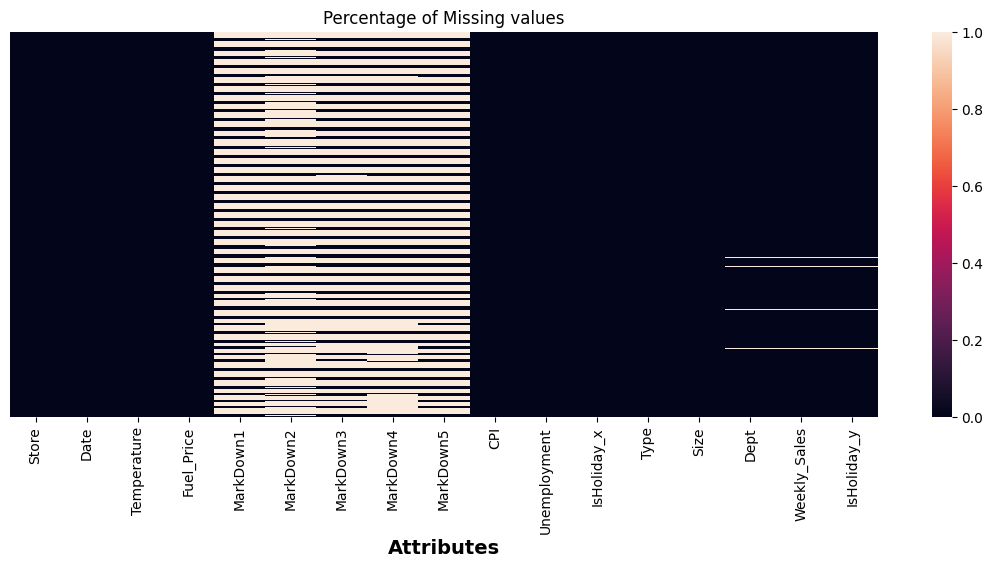

In [30]:
plt.figure(figsize=(14, 5))
sns.heatmap(final_df.isnull(), cbar=True, yticklabels=False)
plt.xlabel("Attributes", size=14, weight="bold")
plt.title("Percentage of Missing values")
plt.show()

In [31]:
duplicates = len(Features_data[Features_data.duplicated()])
print(duplicates)

0


# **Sales by Store Type**

In [32]:
sales_by_type = final_df.groupby('Type')['Weekly_Sales'].mean()
print(sales_by_type)


Type
A    20099.568043
B    12237.075977
C     9519.532538
Name: Weekly_Sales, dtype: float64


# Impact of MarkDowns on Sales

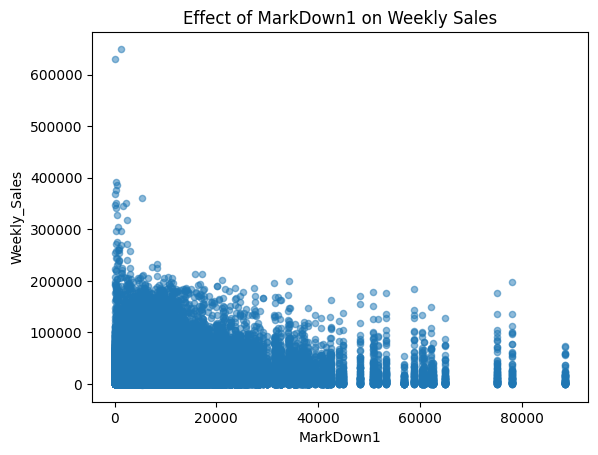

In [33]:
import matplotlib.pyplot as plt

# Example with MarkDown1
final_df[['MarkDown1', 'Weekly_Sales']].dropna().plot.scatter(x='MarkDown1', y='Weekly_Sales', alpha=0.5)
plt.title("Effect of MarkDown1 on Weekly Sales")
plt.show()


# **Store Size vs Sales**

<Axes: title={'center': 'Store Size vs Avg Weekly Sales'}, xlabel='Size'>

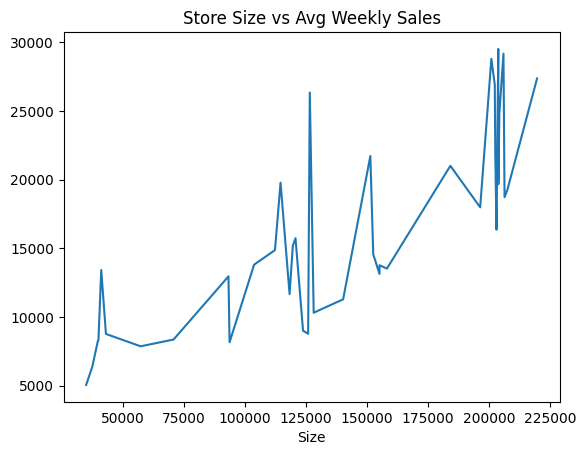

In [34]:
size_sales = final_df.groupby('Size')['Weekly_Sales'].mean()
size_sales.plot(title="Store Size vs Avg Weekly Sales", kind='line')


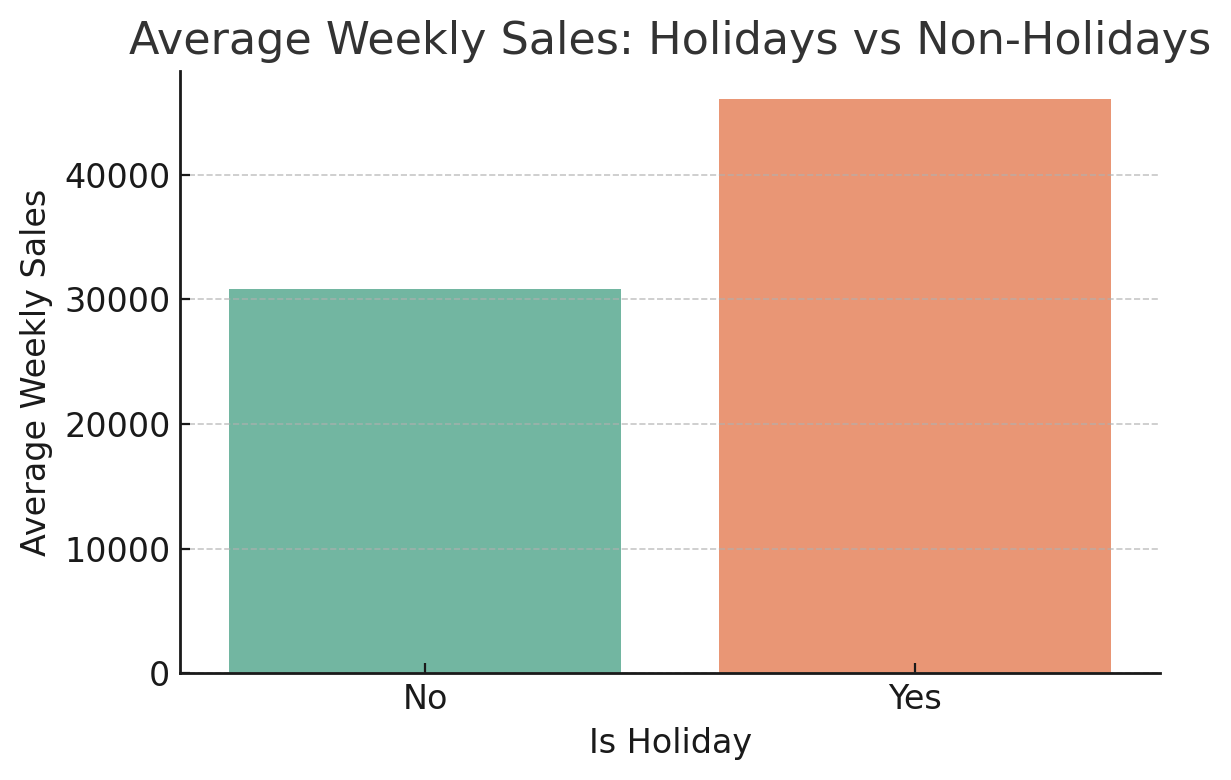

In [35]:
# Example: Weekly Sales Heatmap by Store and Week
pivot_table = final_df.pivot_table(
    values='Weekly_Sales',
    index='Store',
    columns='Date',
    aggfunc='sum',
    fill_value=0
)


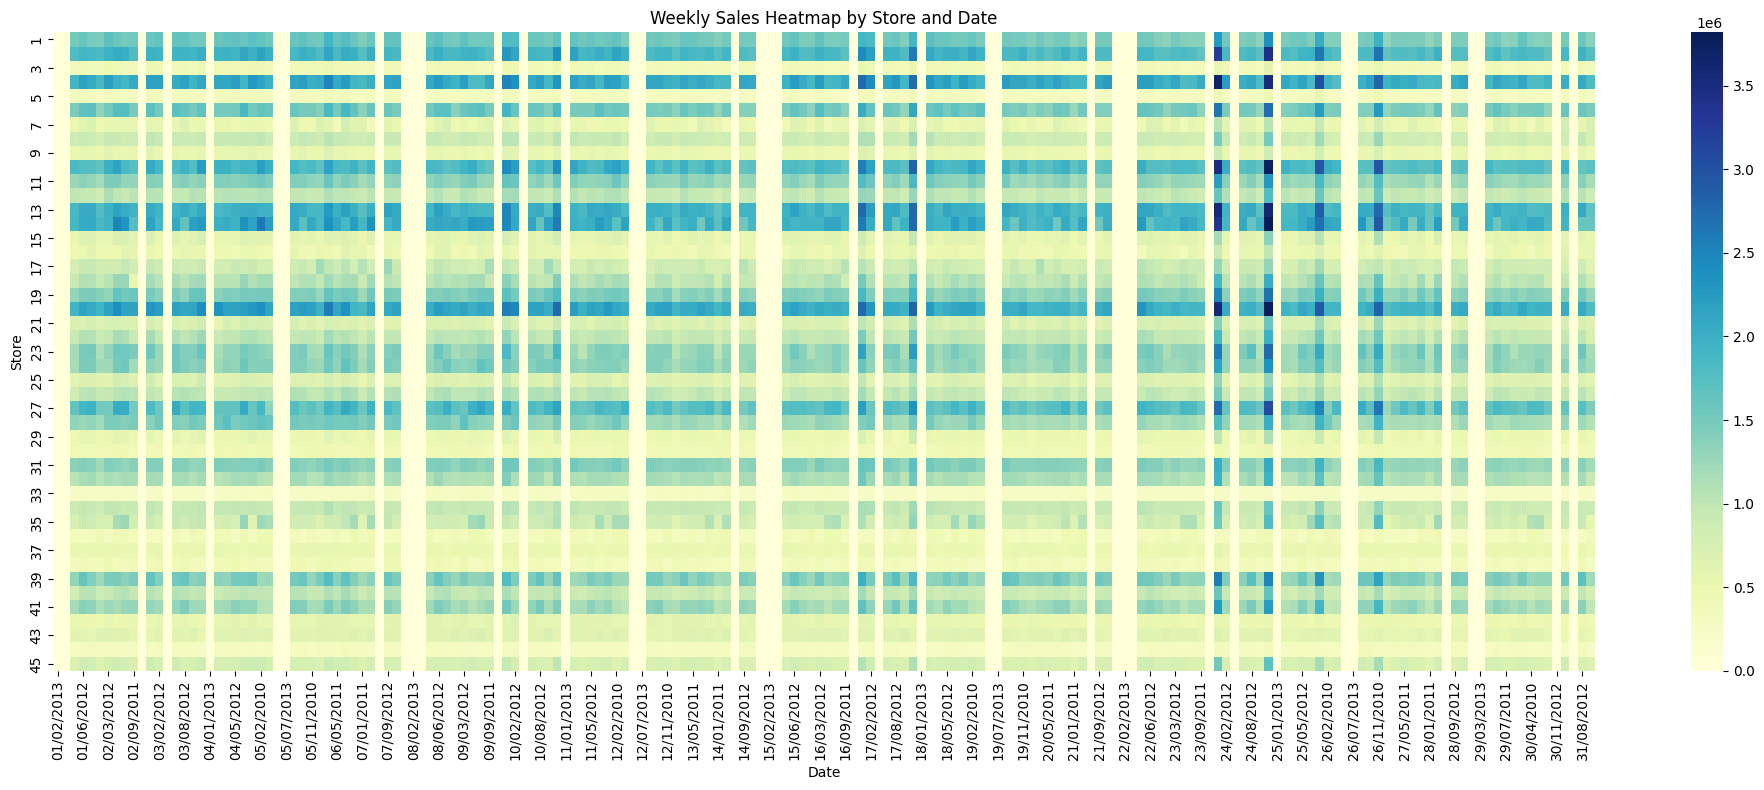

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title("Weekly Sales Heatmap by Store and Date")
plt.xlabel("Date")
plt.ylabel("Store")
plt.tight_layout()
plt.show()



This heatmap visualizes weekly sales across different stores over time. Each row represents a store, and each column represents a date (week). The color intensity indicates the total sales—darker shades mean higher sales, and lighter shades indicate lower sales.” This heatmap helps identify sales performance patterns across stores and time, making it easier for stakeholders to focus on high-performing stores, prepare for seasonal demands, and investigate low-performing periods.

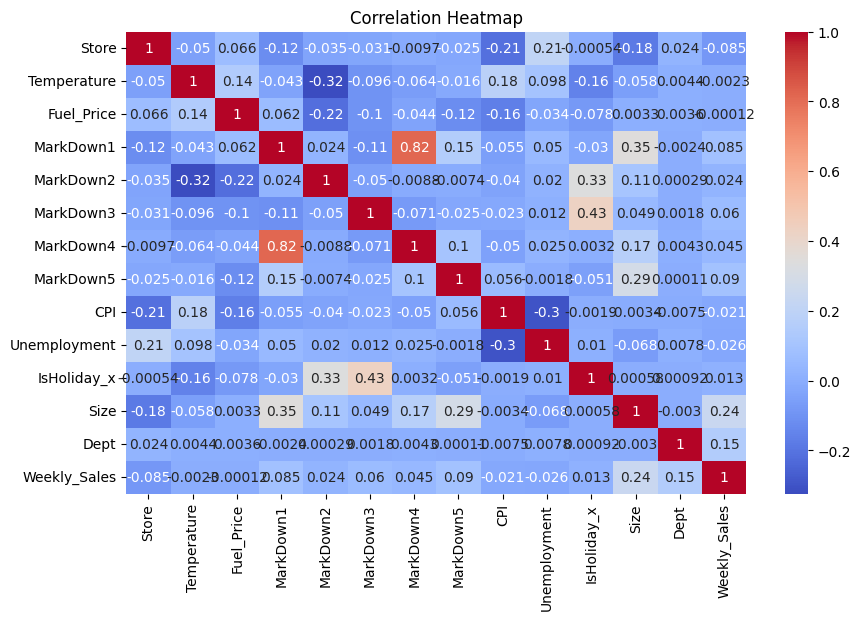

In [37]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(final_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


“A correlation heatmap shows how strongly numerical variables are related to each other. The values range from -1 to +1:
+1 means a perfect positive correlation (as one increases, the other also increases),
-1 means a perfect negative correlation (as one increases, the other decreases),
0 means no correlation.”

I used a correlation heatmap to identify how different factors like temperature, fuel price, markdowns, and CPI affect weekly sales. This helps uncover hidden patterns or influencing factors in retail performance I created a correlation heatmap to study how various numerical features like markdowns, CPI, fuel price, and unemployment relate to weekly sales. I found that certain markdowns like MarkDown1 and MarkDown4 have a positive influence on sales, which indicates that promotions can effectively drive revenue. Other features like Temperature had little impact, which helps in deciding which features to prioritize in predictive modeling.

<function matplotlib.pyplot.show(close=None, block=None)>

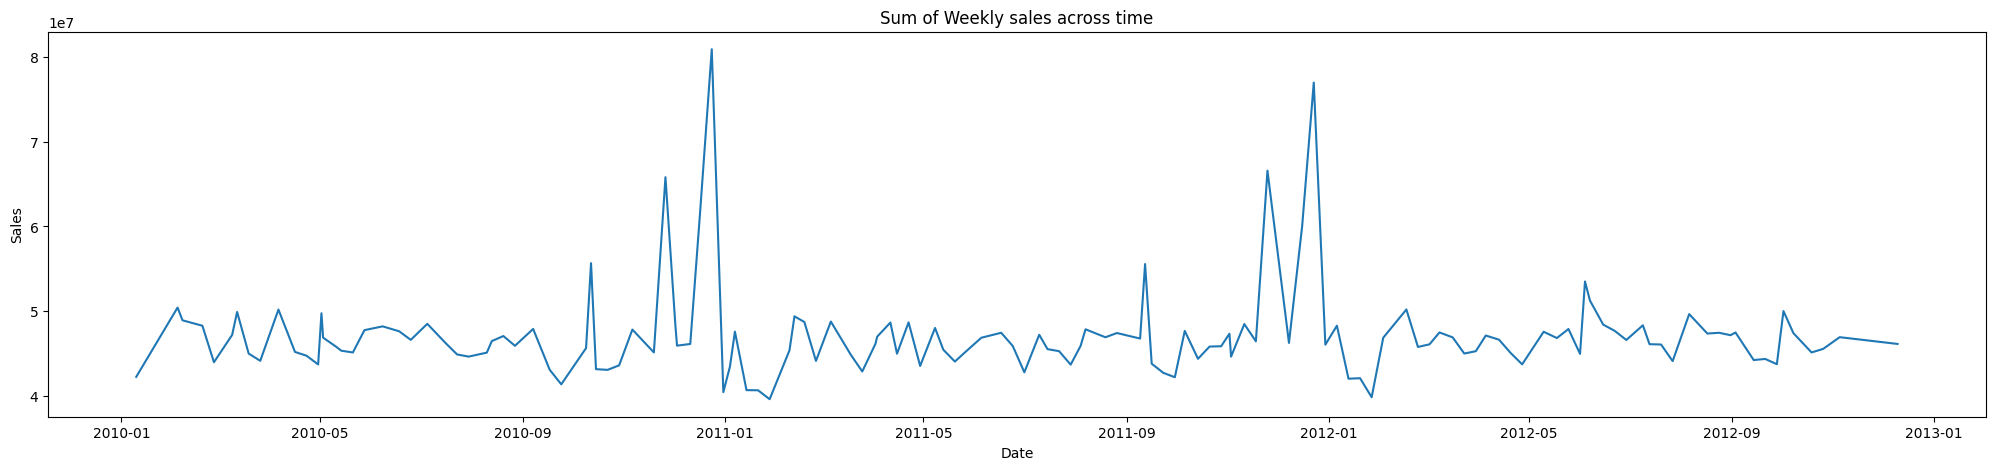

In [38]:
sales_across_time = df_new.groupby(by = ['Date'], as_index = False)['Weekly_Sales'].sum()

plt.figure(figsize = (25,5))
plt.plot(sales_across_time.Date, sales_across_time.Weekly_Sales)
plt.title("Sum of Weekly sales across time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show

<ipython-input-39-1915907424>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = yearly_sales.index, y = yearly_sales.values, palette = 'rocket')


Text(0.5, 0, 'Years')

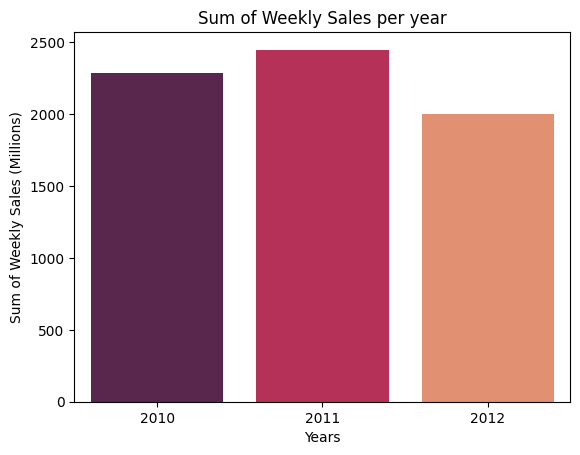

In [39]:
yearly_sales = df_new.groupby(df_new.Date.dt.year)['Weekly_Sales'].sum()/1000000
sns.barplot(x = yearly_sales.index, y = yearly_sales.values, palette = 'rocket')
plt.title("Sum of Weekly Sales per year")
plt.ylabel("Sum of Weekly Sales (Millions)")
plt.xlabel("Years")

<ipython-input-40-2072201146>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = monthly_sales.index, y = monthly_sales.values, palette='flare')


Text(0.5, 1.0, 'Sum of weekly sales per month')

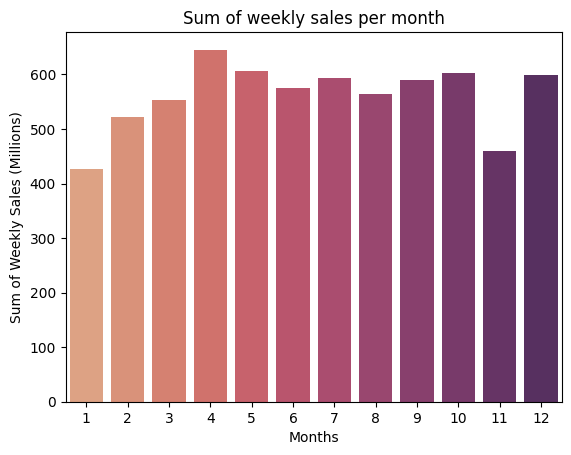

In [40]:
monthly_sales = df_new.groupby(df_new.Date.dt.month)['Weekly_Sales'].sum()/1000000
sns.barplot(x = monthly_sales.index, y = monthly_sales.values, palette='flare')
plt.xlabel('Months')
plt.ylabel('Sum of Weekly Sales (Millions)')
plt.title("Sum of weekly sales per month")

<ipython-input-41-1338896466>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = stores_sales.Store, y = stores_sales.Weekly_Sales , data = stores_sales, palette = 'rocket')


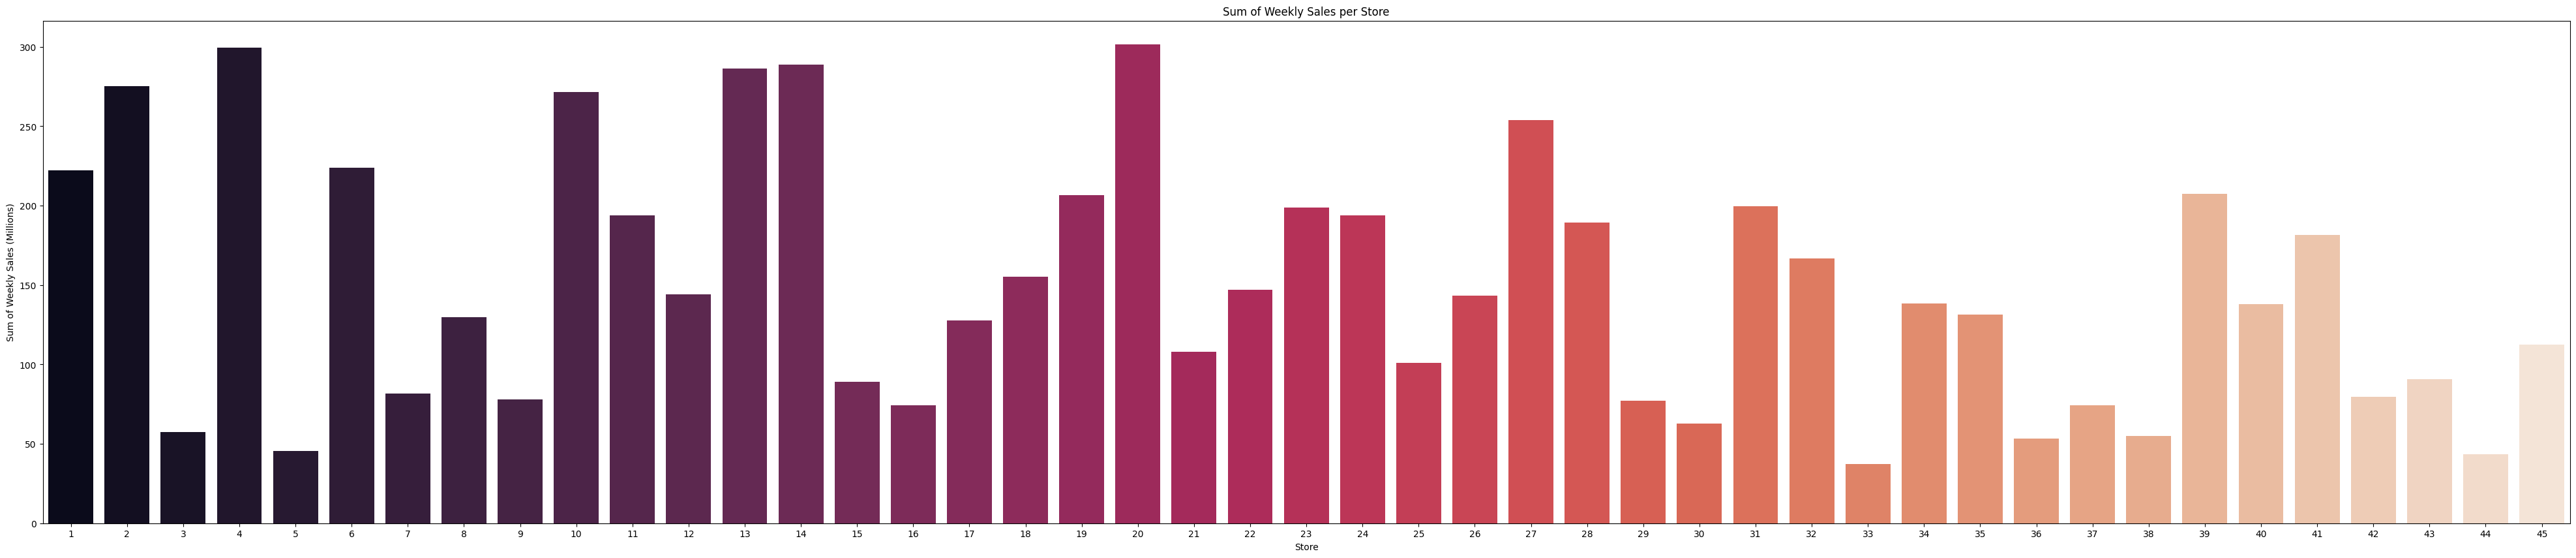

In [41]:
stores_sales = df_new.groupby(by = ['Store'], as_index= False)['Weekly_Sales'].sum()
stores_sales['Weekly_Sales'] = stores_sales['Weekly_Sales']/1000000
plt.figure(figsize= (50,10))
sns.barplot(x = stores_sales.Store, y = stores_sales.Weekly_Sales , data = stores_sales, palette = 'rocket')
plt.xlabel('Store')
plt.ylabel('Sum of Weekly Sales (Millions)')
plt.title('Sum of Weekly Sales per Store')
plt.show()

Findings: Store number 20 and 4 were identified as the top earners based on their weekly sales, while store number 44 and 5 emerged as the least profitable.

<ipython-input-42-856252537>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = type_sales.Type, y = type_sales.Weekly_Sales , data = type_sales, palette = 'rocket')


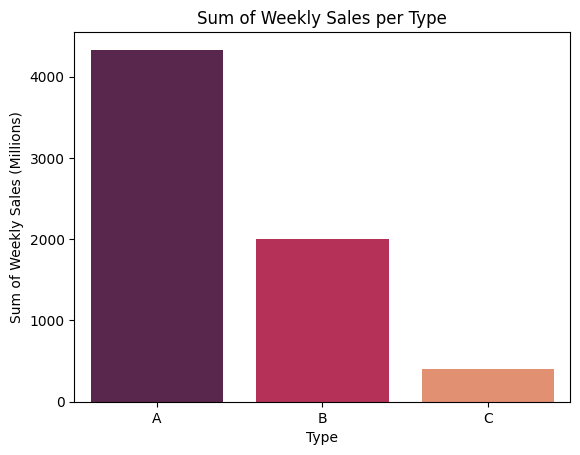

In [42]:
type_sales = df_new.groupby(by = ['Type'], as_index= False)['Weekly_Sales'].sum()
type_sales['Weekly_Sales'] = type_sales['Weekly_Sales']/1000000
sns.barplot(x = type_sales.Type, y = type_sales.Weekly_Sales , data = type_sales, palette = 'rocket')
plt.xlabel('Type')
plt.ylabel('Sum of Weekly Sales (Millions)')
plt.title('Sum of Weekly Sales per Type')
plt.show()

Findings: Store type A, succeeded by store type B, were identified as the store types with the highest earnings, while store type C exhibited the lowest weekly sales.

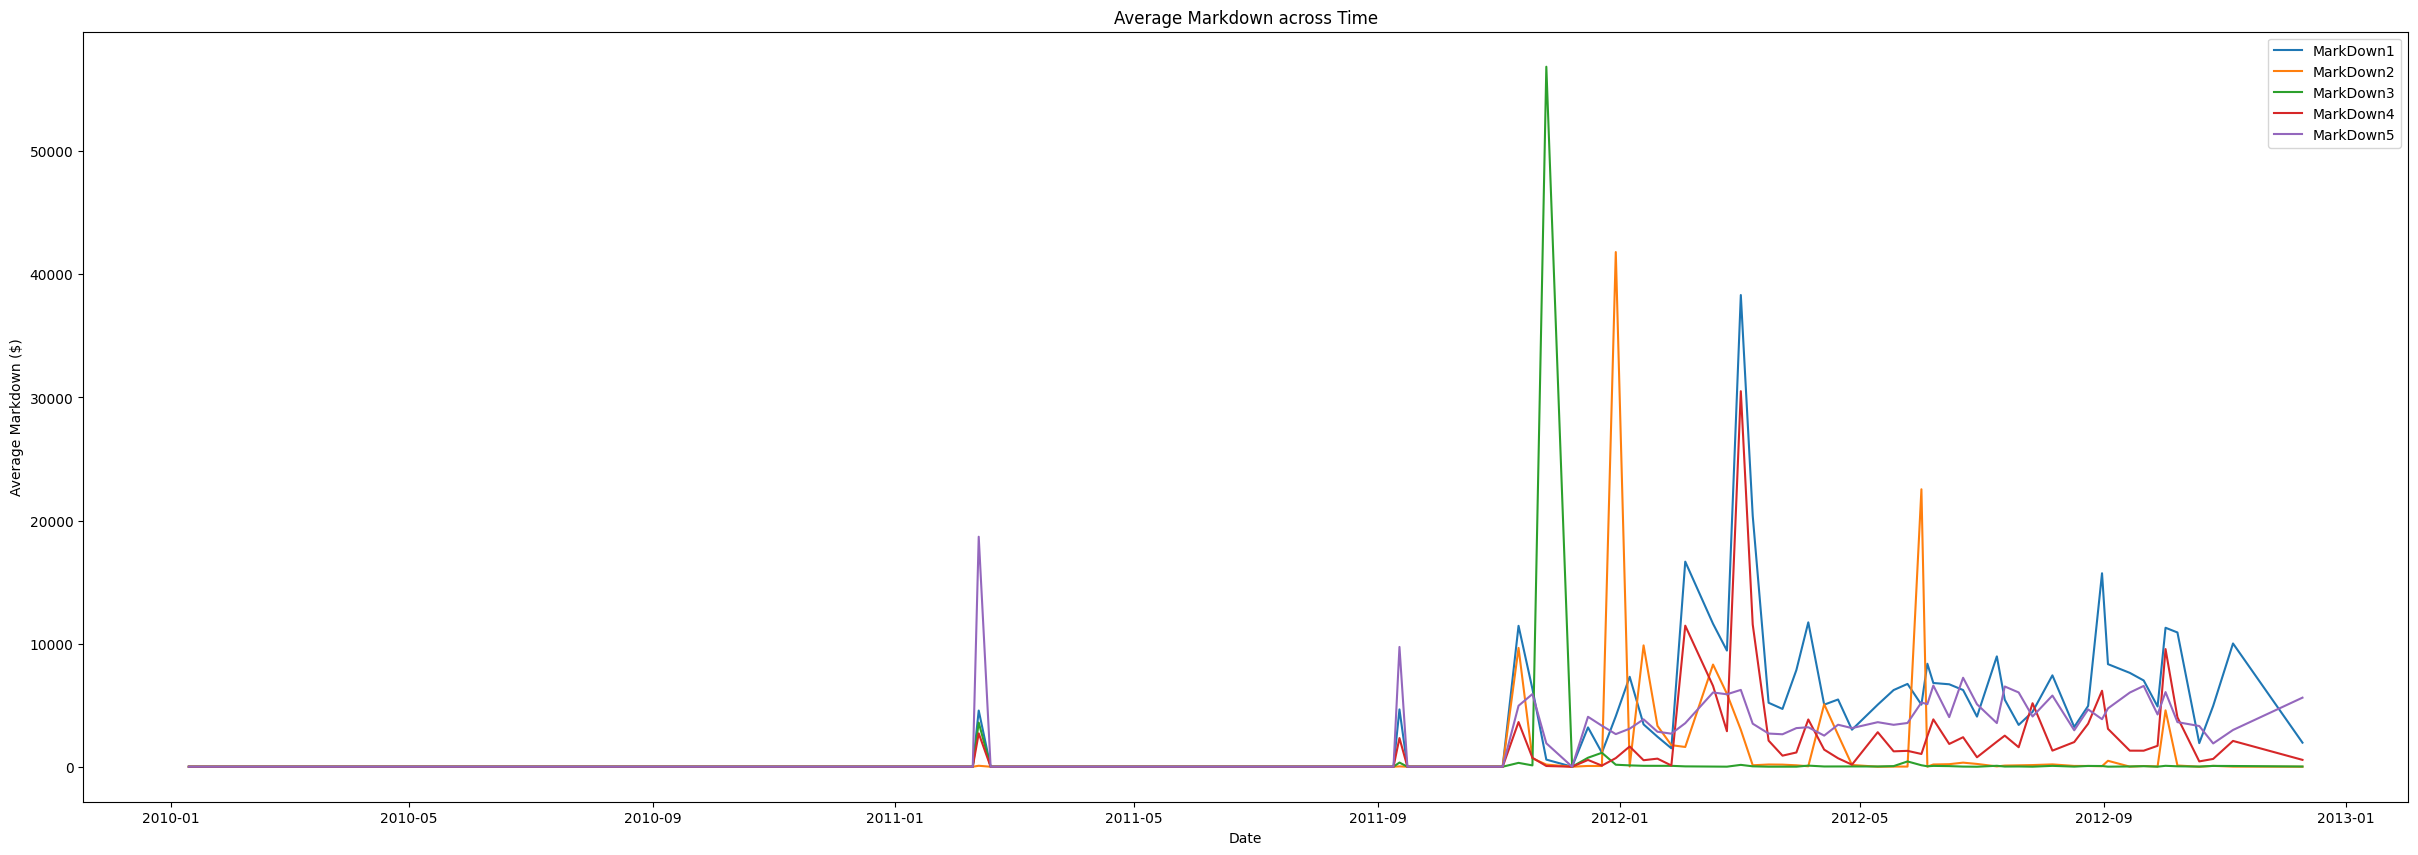

In [43]:
df_markdown = df_new.groupby('Date').agg({'MarkDown1': 'mean', 'MarkDown2': 'mean', 'MarkDown3': 'mean', 'MarkDown4': 'mean', 'MarkDown5': 'mean'})
plt.figure(figsize = (30,10))

plt.plot(df_markdown.index, df_markdown.MarkDown1, label = 'MarkDown1')
plt.plot(df_markdown.index, df_markdown.MarkDown2, label = 'MarkDown2')
plt.plot(df_markdown.index, df_markdown.MarkDown3, label = 'MarkDown3')
plt.plot(df_markdown.index, df_markdown.MarkDown4, label = 'MarkDown4')
plt.plot(df_markdown.index, df_markdown.MarkDown5, label = 'MarkDown5')


plt.xlabel("Date")
plt.ylabel("Average Markdown ($)")
plt.title("Average Markdown across Time")
plt.legend(loc = 'best')

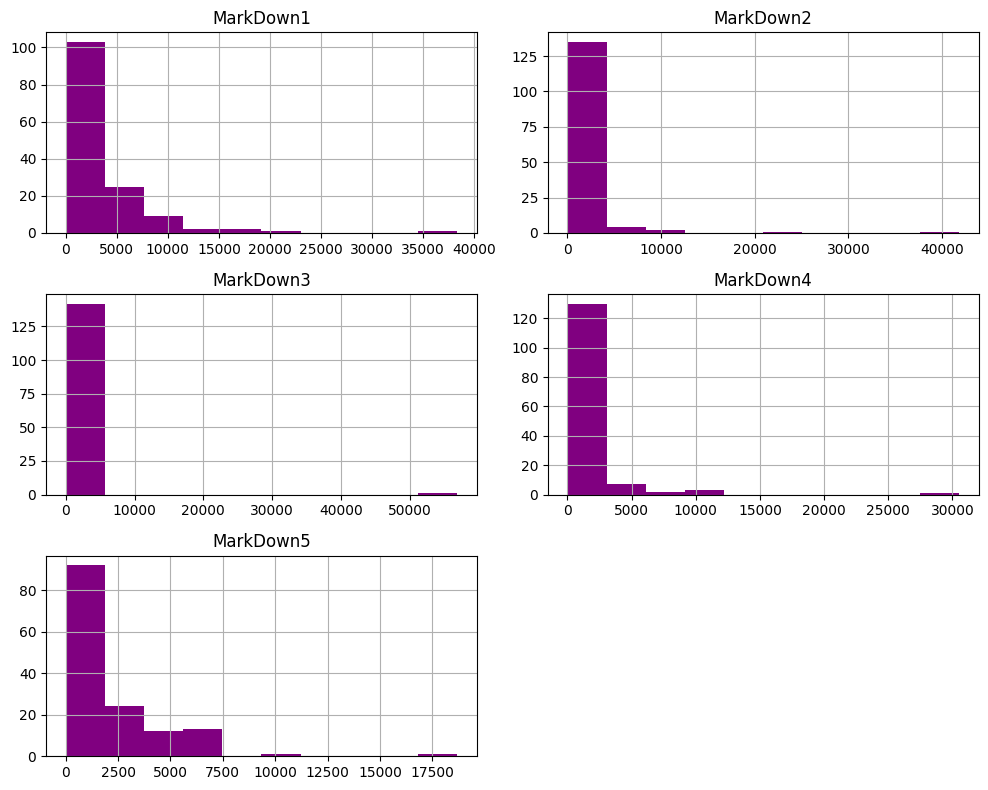

In [44]:

# Frequency of markdown
df_markdown.hist(bins=10, figsize = (10,8), color = 'Purple')
plt.tight_layout()
plt.show()

# Markdown3 is the highest in November

Text(0.5, 1.0, 'Average Markdown per Type')

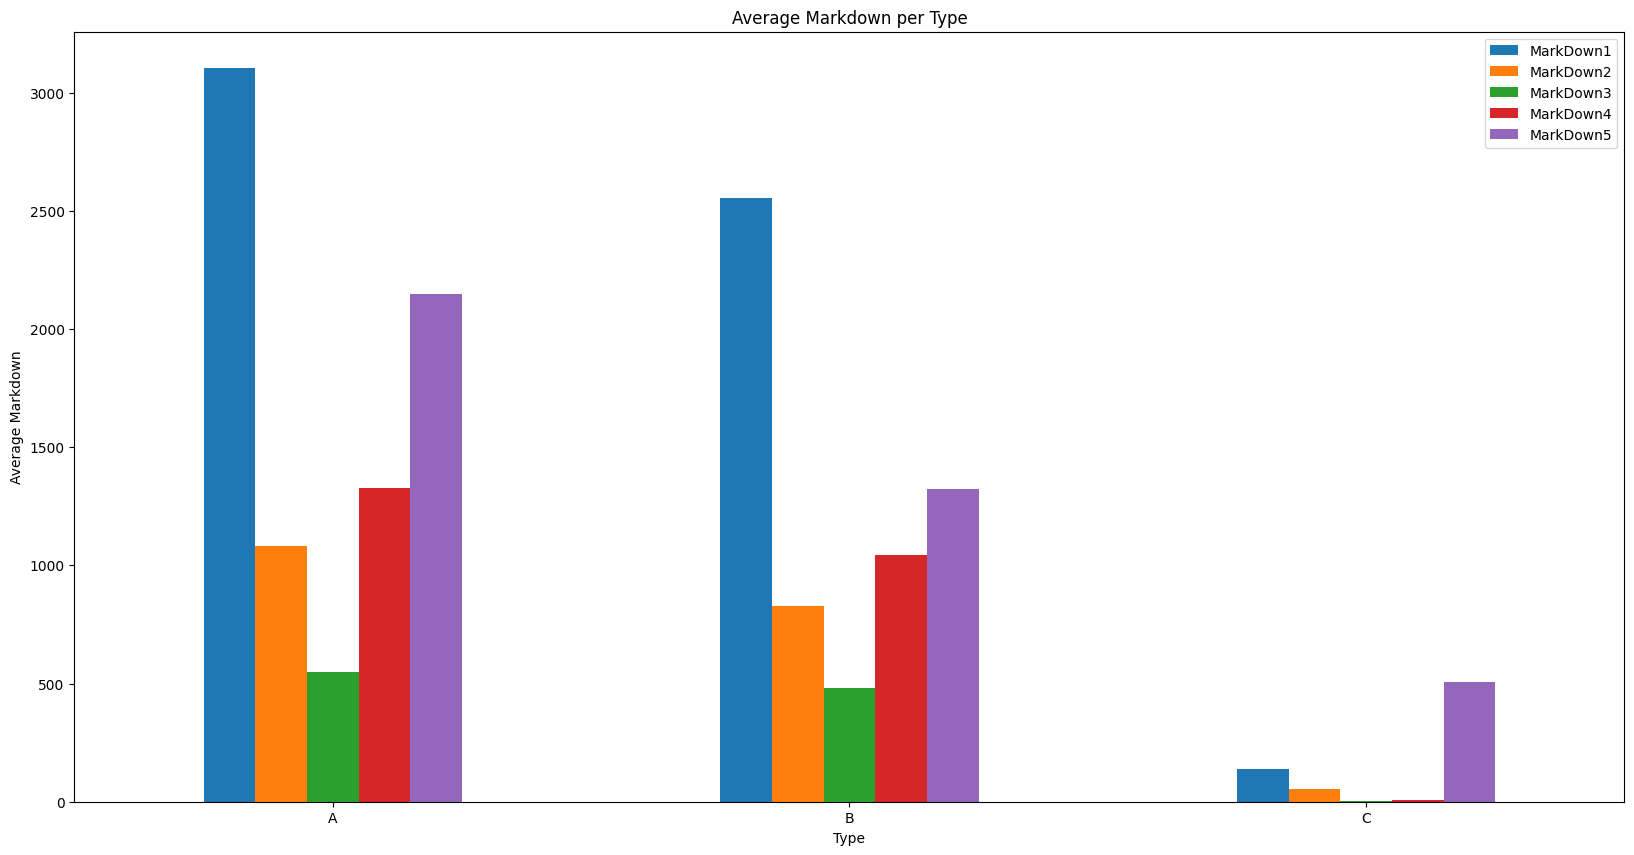

In [45]:

# Markdown across Type
# Markdown across months
df_markdown_type = df_new.groupby(df_new.Type).agg({'MarkDown1': 'mean', 'MarkDown2': 'mean', 'MarkDown3': 'mean', 'MarkDown4': 'mean', 'MarkDown5': 'mean'})
df_markdown_type.head()
df_markdown_type.plot(kind = 'bar', figsize = (20,10), rot = 0)
plt.xlabel("Type")
plt.ylabel('Average Markdown')
plt.title('Average Markdown per Type')

# Markdown1 is the highest in for Type A, B while markdown 5 is the highest for type C


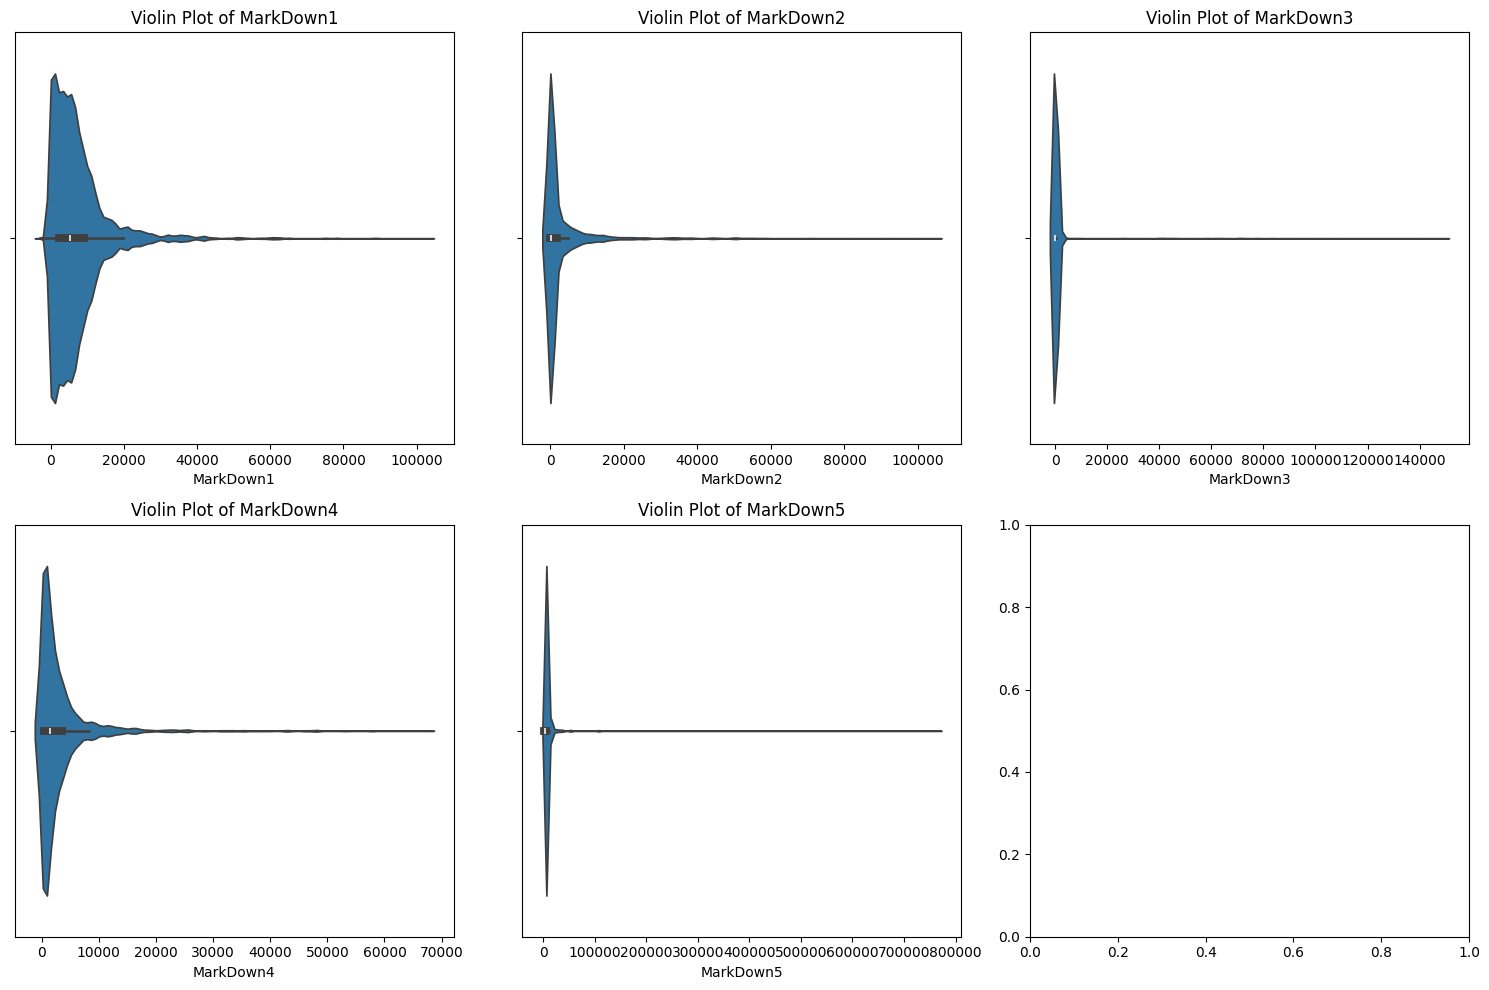

In [46]:
# Define the features for which you want to create violin plots
features = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

# Calculate the number of rows and columns needed
num_features = len(features)
num_rows = num_features // 2
num_cols = 2 if num_features % 2 == 0 else 3  # Adjust for odd number of features

# Set up subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

# Flatten the axes array if needed
if num_rows > 1:
    axes = axes.flatten()

# Iterate over each feature and create a violin plot on its respective subplot
for i, feature in enumerate(features):
    sns.violinplot(data=final_df, x=feature, ax=axes[i])
    axes[i].set_title(f'Violin Plot of {feature}')
    axes[i].set_xlabel(feature)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

The histogram clearly depicts that distribution of Markdown features do not follow a normal distribution, it's right skewed distribution.

Secondly the boxplot shows outliers in Markdown features,the percentage of this outliers are nearly in the range of 5-8 percent of total records.
Handling the Outliers, in this scenerio outlier removal based on IQR threshold value not recommended because it may result in removal of 10% of data from dataset, it lead to data loss and less data availability while training.

We will go forward with robust statistical estimators that are less sensitive to outliers, such as the median instead of the mean imputation of null values.

This will help to make the data distribution more symmetric and reduce the impact of outliers in the Markdown features distribution

# **🧾 📌 Final Output Summary of the Project**

To analyze historical retail data and provide insights for:

Store performance optimization

Demand forecasting

Holiday effect analysis

Customer segmentation



Weekly sales fluctuate with seasonality and holidays.

